In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
from tqdm import tqdm

from dataset import ProteinSmilesDataset
from smiles import AF2SmilesTransformer
from utils import VocSmiles, check_smiles
from trainer import Runner
import os
from torch.utils.data import DataLoader
import time, random
import numpy as np

from rdkit import Chem

## Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

dev = torch.device('cuda')
devices = [0]

In [105]:
model_config = {}

trainer = Runner(model_num=360)

## Testing

protein_targets_file = '/home/andrius/git/datasets/MonoamineR_human_65.txt'
with open(protein_targets_file, 'r') as prot_list:
    target_proteins = prot_list.readlines()
    target_proteins = [t.strip('\n').strip() for t in target_proteins]

smiles = []
smiles_dict = {}
for protein in target_proteins:
    p_smiles = trainer.targetted_generation(protein_id=protein, batch_size=10, repeat=50)
    smiles_dict[protein] = p_smiles

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677


In [15]:
print(target_proteins)

['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']


In [18]:
## Check VALIDITY

def validate(smiles):
    
    valid = []
    scores = check_smiles(smiles)
    for i, smile in enumerate(smiles):
        if scores[i] == 1:
            valid.append(smile)
    
    return valid


valid = {}

for protein in target_proteins:
    valid[protein] = validate(smiles_dict[protein])

valid_percentages = [len(filtered[p])/len(smiles_dict[p]) for p in target_proteins]

print(valid)
print(valid_percentages)      

{'P21917': ['CC[C@H]1CN(Cc2ccc(F)cc2)CCN1C(=O)c1ccc(N2CCN(C)CC2)cc1', 'FC(F)(F)c1ccc(N2CCN(CCCCOc3ccc(CN4CCCCC4)cc3)CC2)cc1', 'O=C1c2c(cccc2)NC2CCN(CC[C@H]3CCc4c(cccc4)C3)C21', 'Cc1nc2c(cccc2CN2CCCc3ccc(Cl)cc32)[nH]1', 'C[C@H]1Cc2c(O1)cc(CN1CCC(c3ccccc3)CC1)cc2', 'CCN1CCc2c(C1)sc1c2c(O)ncc1', 'Cc1ccc(N2CCN(CCCCNC(=O)c3cc4c(cccc4)o3)CC2)cc1', 'COc1ccccc1N1C(=O)C[C@@H](CCN2CCN(c3ccccc3)CC2)C1', 'CCCSc1c(C(N)=O)cc2CCCCc2c1', 'O=C(NCCCCN1CCN(c2ccccc2-c2cccc[n+]2[O-])CC1)c1ccc(F)cc1', 'COc1ncc(N(C2CCN(Cc3ccccc3)CC2)cc1)C1CCN(C)CC1', 'O=C(NCCCCN1CCN(c2cccc(C(F)(F)F)c2)CC1)c1cncs1', 'CCCN1CC=C(C(=O)c2ccc(Cl)cc2)CC1', 'C/CCN=c1\\c(-c2ccc(Cl)cc2)cc(Cl)c1', 'CCCN(CCCCN(CCC)Cc1ccc(-c2ccccc2)cc1)C1Cc2c(cccc2O)C1', 'O=C(CN1CCN(CCN2CCN(c3c(Cl)cccc3)CC2)CC1)N1c2ccccc2Sc2c1cccc2', 'COc1c(C(=O)N[C@H]2CCN(Cc3c(OC)cccc3)C[C@H]2C)ccc(N2CCCCC2)c1', 'OCCc1cc(CN2CCN(c3ccc(Cl)cc3)CC2)c(O)cc1', 'CO/N=C(/CN(C)C)c1ccc(NC(=O)N2CCN(c3ccccc3)CC2)cc1', 'CN(c1ccccc1)C1CCN(Cc2coc3ccccc23)CC1', 'COc1c(C(F)(F)F)cc(C(=O)

In [78]:
## Checking for duplicates (identical SMILES)

non_duplicate = {}
for p in target_proteins:
    smiles_list = valid[p]
    non_dupes = list(set(smiles_list))
    non_duplicate[p] = non_dupes
    print(p, len(smiles_list), len(non_dupes), len(smiles_list) - len(non_dupes))


P21917 376 374 2
Q96RJ0 469 469 0
Q9H3N8 354 351 3
P21728 457 457 0
P28222 300 299 1
P20309 327 325 2
P30939 362 362 0
Q9IP65 422 421 1
Q13639 306 304 2
P28221 324 321 3
P25021 352 352 0
P13945 396 396 0
P08908 424 424 0
P08588 396 396 0
P28223 372 369 3
P25100 345 343 2
P18089 331 329 2
P28335 344 344 0
P35462 456 456 0
P08913 312 311 1
P21918 423 420 3
P50406 297 297 0
P28566 451 450 1
P08912 458 458 0
P18825 333 333 0
Q9Y5N1 350 350 0
P47898 458 458 0
P41595 330 330 0
P35367 317 316 1
P07550 459 459 0
P08172 346 346 0
P14416 455 454 1
P11229 461 461 0
P08173 456 455 1
P35368 350 349 1
P35348 360 359 1


In [119]:
## Canonize to check how many of the generated molecules are unique

non_duplicate_canonized = {}
for p in target_proteins:
    smiles_list = non_duplicate[p]
    canonized = [Chem.CanonSmiles(smile) for smile in smiles_list]
    canonized_non_dupes = list(set(canonized))
    non_duplicate_canonized[p] = canonized_non_dupes
    print(p, len(smiles_list), len(canonized_non_dupes), len(smiles_list) - len(canonized_non_dupes))
    
n_canonized_non_dupes = [len(non_duplicate_canonized[p]) for p in target_proteins]

P21917 374 373 1
Q96RJ0 469 469 0
Q9H3N8 351 351 0
P21728 457 457 0
P28222 299 299 0
P20309 325 325 0
P30939 362 362 0
Q9IP65 421 421 0
Q13639 304 304 0
P28221 321 320 1
P25021 352 352 0
P13945 396 396 0
P08908 424 424 0
P08588 396 396 0
P28223 369 369 0
P25100 343 342 1
P18089 329 328 1
P28335 344 343 1
P35462 456 455 1
P08913 311 311 0
P21918 420 420 0
P50406 297 297 0
P28566 450 450 0
P08912 458 458 0
P18825 333 332 1
Q9Y5N1 350 350 0
P47898 458 458 0
P41595 330 330 0
P35367 316 316 0
P07550 459 459 0
P08172 346 346 0
P14416 454 454 0
P11229 461 461 0
P08173 455 455 0
P35368 349 349 0
P35348 359 357 2


In [29]:
## Load the dataset
from trainer import load_dataset, load_voc
from config import DatasetConfig

config = DatasetConfig()
voc = load_voc(config)

dataset = load_dataset(voc, config)

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
Dataset: len: 484677


In [93]:
# Isolate smiles based on protein id

from utils import standardize_mol

protein_smiles_dict = {}
all_smiles = []
for line in dataset.tsv_dataset:
    pid, pchembl, smiles = line.split('\t')
    tokens = smiles.split(' ')[:-1]
    joined = ''.join(tokens)

    if protein_smiles_dict.get(pid) is not None:
        protein_smiles_dict[pid] += [joined]
    else:
        protein_smiles_dict[pid] = [joined]
        
    all_smiles += [joined]

all_smiles = list(set(all_smiles))

all_smiles_canonized = []
for smile in all_smiles:
    res = check_smiles([smile])
    if res[0][0] != 0:
        canonized = Chem.CanonSmiles(smile)
        all_smiles_canonized += [canonized]
        
        
print(len(all_smiles), len(all_smiles_canonized))

76493 56823


In [136]:
## Check whether generated smiles overlap with the dataset

all_set = set(all_smiles_canonized)
differences = []

for i, protein in enumerate(target_proteins):
    intersect = set(non_duplicate_canonized[protein]).intersection(all_set)
    difference = set(non_duplicate_canonized[protein]).difference(all_set)
    differences += [len(list(difference))]
    print(protein, 
          len(list(intersect)),
          len(list(difference)), round(mean_l[i], 2), min_l[i], max_l[i],
          num_datapoints[i])


P21917 13 360 40.61 9 70 1775
Q96RJ0 58 411 31.31 16 64 47897
Q9H3N8 12 339 38.38 14 70 730
P21728 52 405 31.67 15 57 45289
P28222 9 290 44.97 19 74 775
P20309 15 310 48.96 17 93 1412
P30939 12 350 40.74 7 76 95
Q9IP65 27 394 34.45 14 76 0
Q13639 3 301 48.38 22 98 526
P28221 21 299 44.7 13 83 968
P25021 4 348 43.77 20 77 88
P13945 1 395 53.93 19 97 1355
P08908 43 381 33.52 16 71 13872
P08588 1 395 48.24 18 84 763
P28223 16 353 45.16 3 72 3048
P25100 18 324 47.43 15 88 1210
P18089 6 322 40.77 17 78 294
P28335 9 334 41.9 17 83 1989
P35462 58 397 32.33 16 65 52417
P08913 9 302 40.76 17 78 568
P21918 31 389 34.24 18 77 157
P50406 10 287 43.76 14 73 2572
P28566 67 383 30.46 2 53 10542
P08912 64 394 31.37 16 58 48429
P18825 9 323 40.51 12 81 480
Q9Y5N1 2 348 41.82 17 79 3276
P47898 67 391 31.42 14 51 45848
P41595 7 323 40.3 20 85 992
P35367 3 313 44.34 19 83 842
P07550 54 405 31.3 17 69 48276
P08172 11 335 44.29 20 85 1063
P14416 62 392 32.53 4 70 46590
P11229 71 390 31.53 5 64 49040
P08173 

In [215]:
## Find average length of generated smiles:
mean_l = []
max_l = []
min_l = []

for p in target_proteins:
    lengths = [len(smile) for smile in non_duplicate_canonized[p]]
    mean = np.mean(lengths)
    min_l += [min(lengths)]
    max_l += [max(lengths)]
    mean_l += [mean]
    print(p, mean)

print(target_proteins)
## Find the number of datapoints per protein

data_mean_l = []
target_proteins.remove('Q9IP65')
for p in target_proteins:
    lengths = [len(smile) for smile in protein_smiles_dict[p]]
    mean = np.mean(lengths)
    data_mean_l += [mean]

num_datapoints = [len(protein_smiles_dict[p]) for p in target_proteins]
num_datapoints.insert(7, 0)
data_mean_l.insert(7, 0)
target_proteins.insert(7, 'Q9IP65')
print(target_proteins)
# print(protein_smiles_dict[target_proteins[0]])


P21917 40.605898123324394
Q96RJ0 31.3091684434968
Q9H3N8 38.38176638176638
P21728 31.671772428884026
P28222 44.97324414715719
P20309 48.963076923076926
P30939 40.73756906077348
Q9IP65 34.451306413301666
Q13639 48.38157894736842
P28221 44.696875
P25021 43.76704545454545
P13945 53.93181818181818
P08908 33.52122641509434
P08588 48.24242424242424
P28223 45.16260162601626
P25100 47.432748538011694
P18089 40.76829268292683
P28335 41.90087463556851
P35462 32.325274725274724
P08913 40.758842443729904
P21918 34.23809523809524
P50406 43.76094276094276
P28566 30.464444444444446
P08912 31.366812227074234
P18825 40.50903614457831
Q9Y5N1 41.817142857142855
P47898 31.421397379912662
P41595 40.3
P35367 44.33860759493671
P07550 31.30065359477124
P08172 44.28901734104046
P14416 32.53303964757709
P11229 31.529284164859003
P08173 31.167032967032966
P35368 47.550143266475644
P35348 48.16526610644258
['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021

In [184]:
from alphafold.papyrus import *

folder = '/media/andrius/Extreme SSD/datasets/foldedPapyrus/proteins'
proteins = [load_protein_sequence(pid, folder) for pid in target_proteins]
headers = [p.info for p in proteins]
names = [h.split('|')[2].split('OS')[0] for h in headers]
print(names)

['DRD4_HUMAN D(4) dopamine receptor ', 'TAAR1_HUMAN Trace amine-associated receptor 1 ', 'HRH4_HUMAN Histamine H4 receptor ', 'DRD1_HUMAN D(1A) dopamine receptor ', '5HT1B_HUMAN 5-hydroxytryptamine receptor 1B ', 'ACM3_HUMAN Muscarinic acetylcholine receptor M3 ', '5HT1F_HUMAN 5-hydroxytryptamine receptor 1F ', 'Q9IP65_HCMV G protein-coupled receptor ', '5HT4R_HUMAN 5-hydroxytryptamine receptor 4 ', '5HT1D_HUMAN 5-hydroxytryptamine receptor 1D ', 'HRH2_HUMAN Histamine H2 receptor ', 'ADRB3_HUMAN Beta-3 adrenergic receptor ', '5HT1A_HUMAN 5-hydroxytryptamine receptor 1A ', 'ADRB1_HUMAN Beta-1 adrenergic receptor ', '5HT2A_HUMAN 5-hydroxytryptamine receptor 2A ', 'ADA1D_HUMAN Alpha-1D adrenergic receptor ', 'ADA2B_HUMAN Alpha-2B adrenergic receptor ', '5HT2C_HUMAN 5-hydroxytryptamine receptor 2C ', 'DRD3_HUMAN D(3) dopamine receptor ', 'ADA2A_HUMAN Alpha-2A adrenergic receptor ', 'DRD5_HUMAN D(1B) dopamine receptor ', '5HT6R_HUMAN 5-hydroxytryptamine receptor 6 ', '5HT1E_HUMAN 5-hydroxyt

['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']


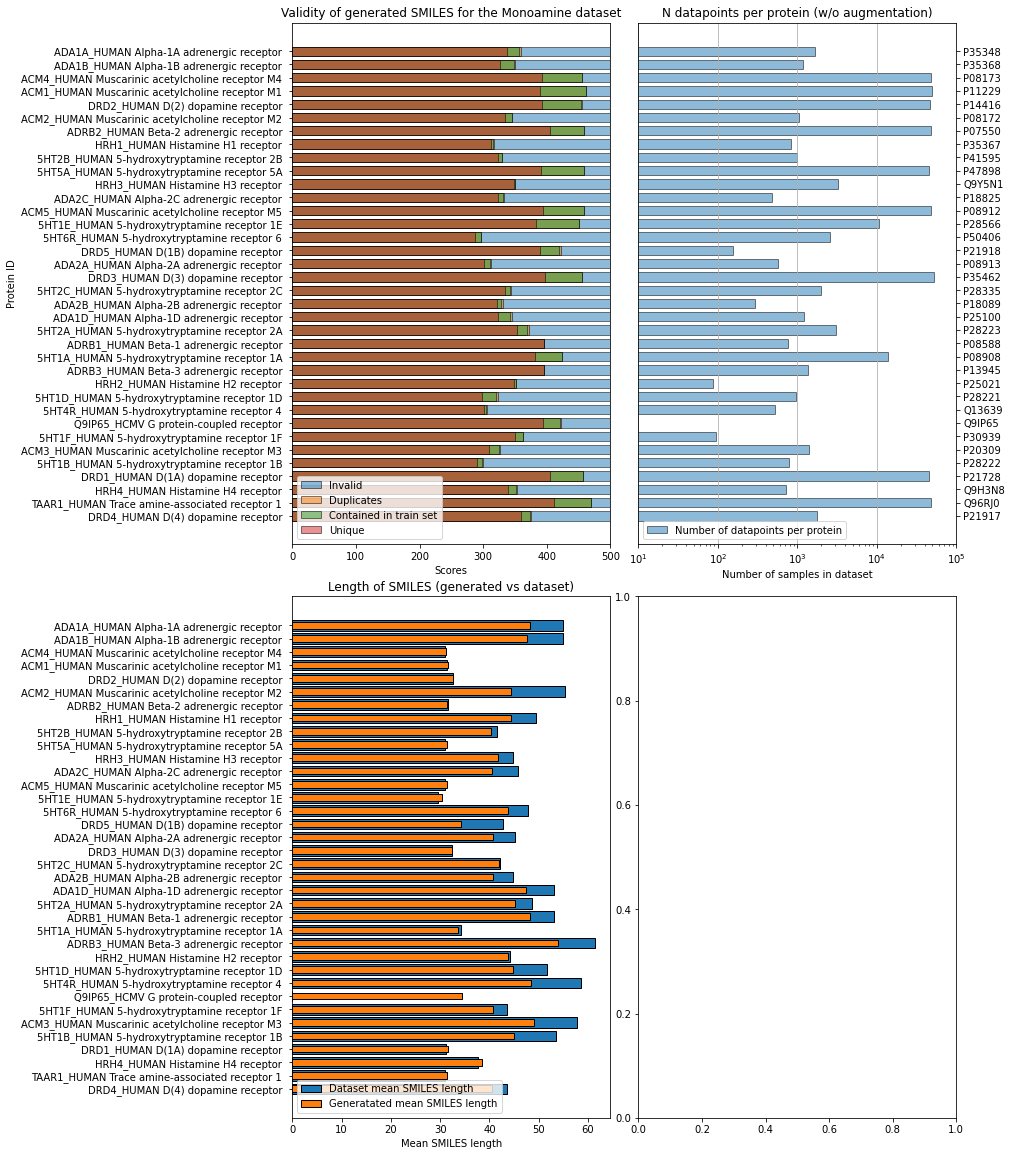

In [247]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,16)

fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(2, 2)
labels = target_proteins
width = 0.7
alpha = 0.5

# print(len(list(difference)), len(valid_percentages))
# print(valid_percentages[0], n_canonized_non_dupes[0], differences[0])
valid = [v * 500 for v in valid_percentages]
total = [500 for _ in range(len(valid))]

## 1 ##
ax.barh(names, total, width, label='Invalid', alpha=alpha, edgecolor='k')
ax.barh(names, valid, width, label='Duplicates', alpha=alpha, edgecolor='k')
ax.barh(names, n_canonized_non_dupes, width, label='Contained in train set', alpha=alpha, edgecolor='k')
ax.barh(names, differences, width, label='Unique', alpha=alpha, edgecolor='k')
ax.set_xlabel('Scores')
ax.set_ylabel('Protein ID')
ax.set_xlim(0, 500)
ax.set_title('Validity of generated SMILES for the Monoamine dataset')
ax.legend(loc='lower left')

## 2 ##
ax2.barh(labels, num_datapoints, width, label='Number of datapoints per protein', alpha=0.5, edgecolor='k')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Number of samples in dataset')
ax2.set_xscale('log')
ax2.set_xlim(10e0, 10e4)
ax2.grid(axis='x')
ax2.set_title('N datapoints per protein (w/o augmentation)')
ax2.legend(loc='lower left')

## 3 ##
ax3.barh(names, data_mean_l, 0.8, label='Dataset mean SMILES length', alpha=1, edgecolor='k')
ax3.barh(names, mean_l, width-0.2, label='Generatated mean SMILES length', alpha=1, edgecolor='k')

ax3.set_xlabel('Mean SMILES length')
ax3.set_title('Length of SMILES (generated vs dataset)')
ax3.legend(loc='lower left')


print(labels)
fig.tight_layout(pad=0.5)
plt.show()


top_targets = ['Q96RJ0', 'P21728', 'P35462', 'P08912', 'P47898', 'P07550', 'P14416', 'P11229', 'P08173']

In [236]:
print(proteins[0].info)
print(proteins[0].seq)

>sp|P21917|DRD4_HUMAN D(4) dopamine receptor OS=Homo sapiens OX=9606 GN=DRD4 PE=1 SV=3

MGNRSTADADGLLAGRGPAAGASAGASAGLAGQGAAALVGGVLLIGAVLAGNSLVCVSVATERALQTPTNSFIVSLAAADLLLALLVLPLFVYSEVQGGAWLLSPRLCDALMAMDVMLCTASIFNLCAISVDRFVAVAVPLRYNRQGGSRRQLLLIGATWLLSAAVAAPVLCGLNDVRGRDPAVCRLEDRDYVVYSSVCSFFLPCPLMLLLYWATFRGLQRWEVARRAKLHGRAPRRPSGPGPPSPTPPAPRLPQDPCGPDCAPPAPGLPRGPCGPDCAPAAPSLPQDPCGPDCAPPAPGLPPDPCGSNCAPPDAVRAAALPPQTPPQTRRRRRAKITGRERKAMRVLPVVVGAFLLCWTPFFVVHITQALCPACSVPPRLVSAVTWLGYVNSALNPVIYTVFNAEFRNVFRKALRACC
